# 1. 위도, 경도로 거리 구하는 프로그램

In [1]:
import numbers
import math

class GeoUtil:
    """
    Geographical Utils
    실제 km를 알고 싶다면 haversine 를 이용하고
    그렇지 않고 더 빠른 속도로 단순 비교를 위한 용도라면 euclidean 를 이용할 수 있다.
    
    인용: https://blog.naver.com/wideeyed/221406744173
    """
    @staticmethod
    def degree2radius(degree):
        return degree * (math.pi/180)
    
    @staticmethod
    def get_harversion_distance(x1, y1, x2, y2, round_decimal_digits=5):
        """
        경위도 (x1,y1)과 (x2,y2) 점의 거리를 반환
        Harversion Formula 이용하여 2개의 경위도간 거래를 구함(단위:Km)
        """
        if x1 is None or y1 is None or x2 is None or y2 is None:
            return None
        assert isinstance(x1, numbers.Number) and -180 <= x1 and x1 <= 180
        assert isinstance(y1, numbers.Number) and  -90 <= y1 and y1 <=  90
        assert isinstance(x2, numbers.Number) and -180 <= x2 and x2 <= 180
        assert isinstance(y2, numbers.Number) and  -90 <= y2 and y2 <=  90

        R = 6371 # 지구의 반경(단위: km)
        dLon = GeoUtil.degree2radius(x2-x1)    
        dLat = GeoUtil.degree2radius(y2-y1)

        a = math.sin(dLat/2) * math.sin(dLat/2) \
            + (math.cos(GeoUtil.degree2radius(y1)) \
              *math.cos(GeoUtil.degree2radius(y2)) \
              *math.sin(dLon/2) * math.sin(dLon/2))
        b = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
        return round(R * b, round_decimal_digits)

    @staticmethod
    def get_euclidean_distance(x1, y1, x2, y2, round_decimal_digits=5):        
        """
        유클리안 Formula 이용하여 (x1,y1)과 (x2,y2) 점의 거리를 반환
        """
        if x1 is None or y1 is None or x2 is None or y2 is None:
            return None
        assert isinstance(x1, numbers.Number) and -180 <= x1 and x1 <= 180
        assert isinstance(y1, numbers.Number) and  -90 <= y1 and y1 <=  90
        assert isinstance(x2, numbers.Number) and -180 <= x2 and x2 <= 180
        assert isinstance(y2, numbers.Number) and  -90 <= y2 and y2 <=  90

        dLon = abs(x2-x1) # 경도 차이
        if dLon >= 180:   # 반대편으로 갈 수 있는 경우
            dLon -= 360   # 반대편 각을 구한다
        dLat = y2-y1      # 위도 차이
        return round(math.sqrt(pow(dLon,2)+pow(dLat,2)),round_decimal_digits)

In [2]:
GeoUtil.get_harversion_distance(126.97843, 37.56668, 127.02758, 37.49794) # 테스트

8.78676

# 2. 각 정류장에 대해 
# 가장 인접한 정류장과의 거리 계산 프로그램
### 오류 발견/수정... 내가 멍청한걸로... 
### 괜히 오픈소스 가져온 함수 이상하다고 욕핸...

In [3]:
import sys

def get_dist_from_most_adjacent_station_per_each_station(df):
    local_X_list, local_Y_list = list(df['LOCAL_X']), list(df['LOCAL_Y'])
    local_list = [(local_X_list[i], local_Y_list[i]) for i in range(len(local_X_list))]
    
    min_dist_list = []

    for i in range(len(local_list)):
        minimum = sys.maxsize
        
        temp = 0
        
        for j in range(len(local_list)):
            if i == j:
                continue

            dist = GeoUtil.get_harversion_distance(local_list[i][0], local_list[i][1],
                                                   local_list[j][0], local_list[j][1])
            if minimum > dist:
                temp = j
                minimum = dist

        if dist == 0:
            print(i, j)

        dist = minimum
        min_dist_list.append(dist)

    min_dist_list.sort()
    min_dist_list = pd.Series(min_dist_list)
    
    return min_dist_list

# 3. 제주도 수행 결과

In [4]:
import pandas as pd

path = r'D:\jeju_bus_data_no_leakage\station'.replace('\\', '/')
result_path = r'C:\Users\think\Desktop\버스 정류장 클러스터링'.replace('\\', '/')
df = pd.read_csv(path + '/' + 'station_final.csv', encoding='ansi')
df['city'] = df['STATION_ADDR']
df.loc[:, 'city'] = df.loc[:, 'STATION_ADDR'].apply(lambda string: string.split(' ')[0])

import matplotlib.pyplot as plt
import numpy as np

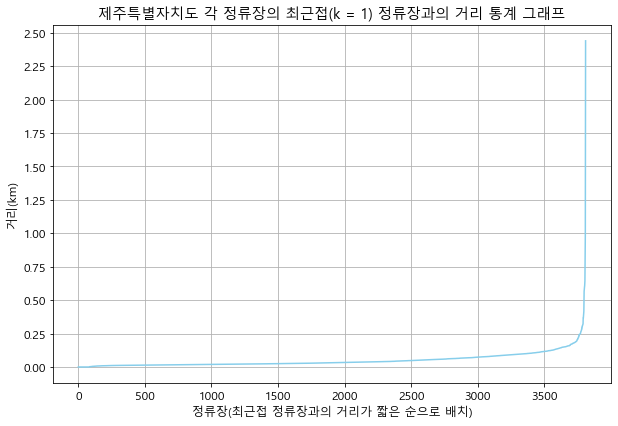

In [5]:
min_dist_list = get_dist_from_most_adjacent_station_per_each_station(df)
jejudo = pd.Series(min_dist_list)

fig_title = '제주특별자치도 각 정류장의 최근접(k = 1) 정류장과의 거리 통계 그래프'

plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.figure(figsize=(10, 6.6))
# 6:4 = 10: 6.6 ... plt.rcParams['figure.figsize']

plt.yticks(np.linspace(0, 2.5, 11))

plt.grid()
plt.rc('font', family='Malgun Gothic')
plt.title(fig_title)
plt.xlabel('정류장(최근접 정류장과의 거리가 짧은 순으로 배치)')
plt.ylabel('거리(km)')
plt.plot(jejudo, color = 'skyblue')
plt.gcf().savefig(result_path + '/' + fig_title)
plt.show()

In [6]:
min_dist_list.mean(), min_dist_list.max(), min_dist_list.min() # 단위: km

(0.051308692913385925, 2.44, 0.0)

In [7]:
jejudo[2500]

0.04808

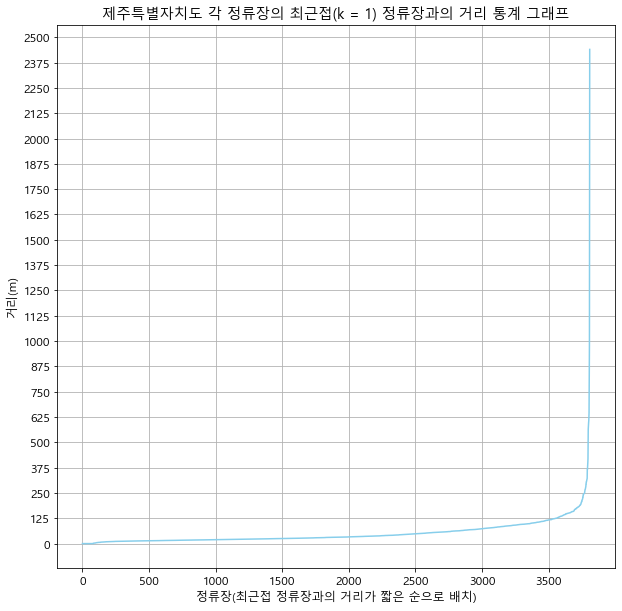

In [8]:
fig_title = '제주특별자치도 각 정류장의 최근접(k = 1) 정류장과의 거리 통계 그래프'

jejudo = jejudo * 1000

plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.figure(figsize=(10, 10))
plt.yticks(np.linspace(0, 2500, 21))
# 6:4 = 10: 6.6 ... plt.rcParams['figure.figsize']
plt.grid()
plt.rc('font', family='Malgun Gothic')
plt.title(fig_title)
plt.xlabel('정류장(최근접 정류장과의 거리가 짧은 순으로 배치)')
plt.ylabel('거리(m)')
plt.plot(jejudo, color = 'skyblue')
plt.gcf().savefig(result_path + '/' + 'm단위 ' + fig_title)
plt.show()

# 4. 서귀포시 수행 결과

In [9]:
seogwipo_city_station_df = df.query('city == "서귀포시"')

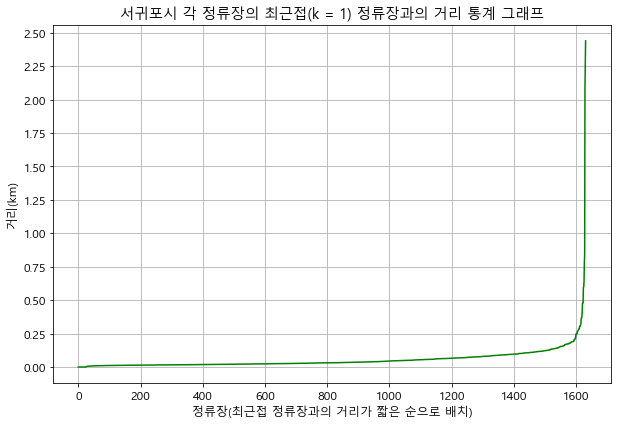

In [10]:
min_dist_list = get_dist_from_most_adjacent_station_per_each_station(seogwipo_city_station_df)
seogwipo = pd.Series(min_dist_list)

fig_title = '서귀포시 각 정류장의 최근접(k = 1) 정류장과의 거리 통계 그래프'

plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.figure(figsize=(10, 6.6))
plt.yticks(np.linspace(0, 2.5, 11))

# 6:4 = 10: 6.6 ... plt.rcParams['figure.figsize']
plt.grid()
plt.rc('font', family='Malgun Gothic')
plt.title(fig_title)
plt.xlabel('정류장(최근접 정류장과의 거리가 짧은 순으로 배치)')
plt.ylabel('거리(km)')
plt.plot(seogwipo, color = 'green')
plt.gcf().savefig(result_path + '/' + fig_title)
plt.show()

In [11]:
min_dist_list.mean(), min_dist_list.max(), min_dist_list.min() # 단위: km

(0.05705143382352934, 2.44, 0.0)

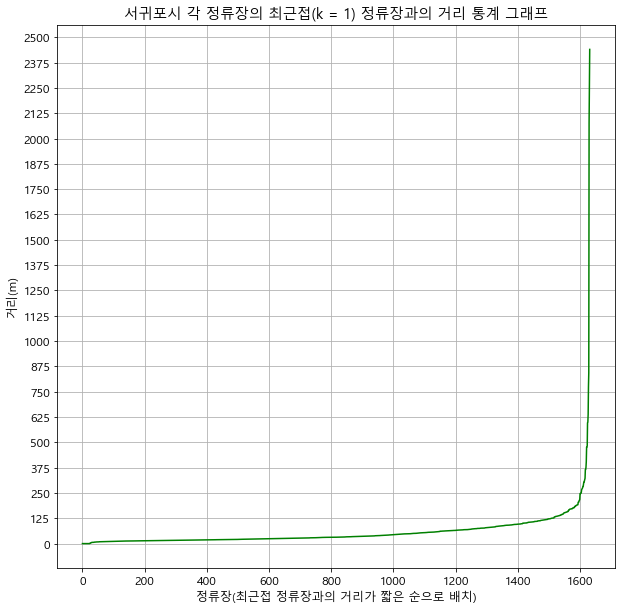

In [16]:
fig_title = '서귀포시 각 정류장의 최근접(k = 1) 정류장과의 거리 통계 그래프'

# seogwipo = seogwipo * 1000

plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.figure(figsize=(10, 10))
plt.yticks(np.linspace(0, 2500, 21))

# 6:4 = 10: 6.6 ... plt.rcParams['figure.figsize']
plt.grid()
plt.rc('font', family='Malgun Gothic')
plt.title(fig_title)
plt.xlabel('정류장(최근접 정류장과의 거리가 짧은 순으로 배치)')
plt.ylabel('거리(m)')
plt.plot(seogwipo, color = 'green')
plt.gcf().savefig(result_path + '/' + 'm단위 ' + fig_title)
plt.show()

# 5. 제주시 수행 결과

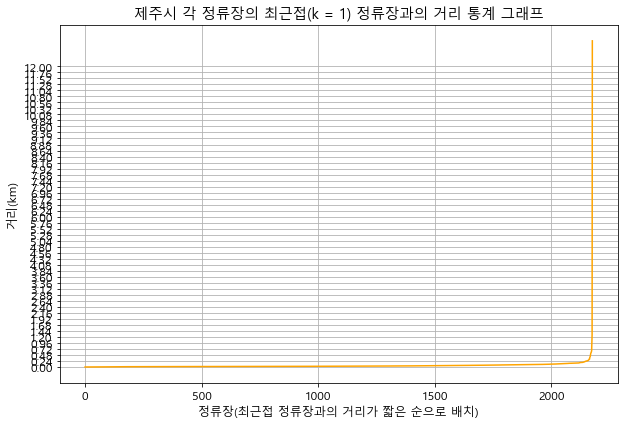

In [13]:
jeju_city_station_df = df.query('city == "제주시"')
min_dist_list = get_dist_from_most_adjacent_station_per_each_station(jeju_city_station_df)
jejusi = pd.Series(min_dist_list)

fig_title = '제주시 각 정류장의 최근접(k = 1) 정류장과의 거리 통계 그래프'

plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.figure(figsize=(10, 6.6))
# 6:4 = 10: 6.6 ... plt.rcParams['figure.figsize']
plt.grid()
plt.rc('font', family='Malgun Gothic')
plt.title(fig_title)
plt.xlabel('정류장(최근접 정류장과의 거리가 짧은 순으로 배치)')
plt.ylabel('거리(km)')
plt.plot(jejusi, color = 'orange')
plt.gcf().savefig(result_path + '/' + fig_title)
plt.show()

In [14]:
min_dist_list.mean(), min_dist_list.max(), min_dist_list.min() # 단위: km

(0.05567027089072537, 13.01806, 0.0)

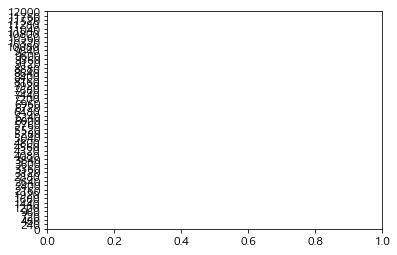

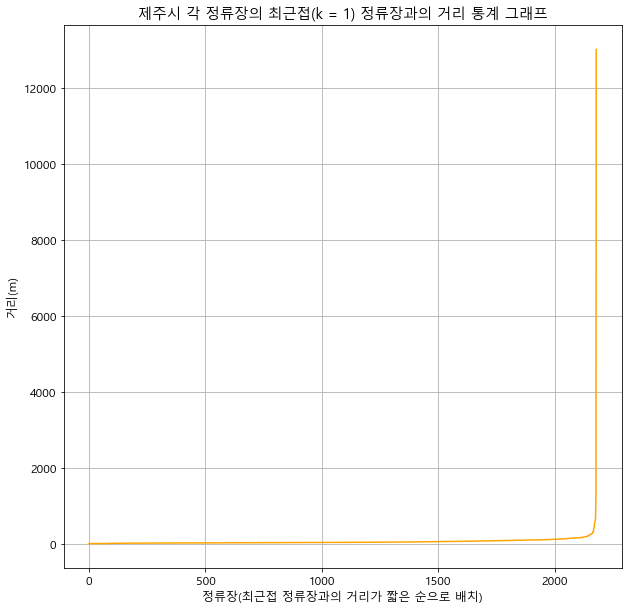

In [15]:
fig_title = '제주시 각 정류장의 최근접(k = 1) 정류장과의 거리 통계 그래프'

jejusi = jejusi * 1000

plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'Malgun Gothic'

plt.figure(figsize=(10, 10))

# 6:4 = 10: 6.6 ... plt.rcParams['figure.figsize']
plt.grid()
plt.rc('font', family='Malgun Gothic')
plt.title(fig_title)
plt.xlabel('정류장(최근접 정류장과의 거리가 짧은 순으로 배치)')
plt.ylabel('거리(m)')
plt.plot(jejusi, color = 'orange')
plt.gcf().savefig(result_path + '/' + 'm단위 ' + fig_title)
plt.show()